In [36]:
import math
import re
from collections import Counter, defaultdict
import itertools
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer

import networkx as nx
from networkx.algorithms import community

import matplotlib.pyplot as plt

In [37]:
QUERY = "cat:cs.LG OR machine learning"
MAX_PAPERS = 300
BATCH = 100
PAUSE_SECONDS = 3 # пауза между запросами

## Сбор данных
Используем API arXiv для загрузки публикаций по запросу *machine learning* и смежным категориям.
Загружено 258 статей, каждая содержит: идентификатор, название, авторов, аннотацию, дату публикации. Т.к.  запрос возвращал не более 100 статей, делали повторные запросы с проверкой на отсутствие дублирования id.

`getattr()` поможет безопасно обработать хоть словарь, хоть объект.                                        Используем категории: машинное обучение, искуственный интелект, статистика/ML.


In [38]:
import arxiv
from tqdm import tqdm

def fetch_arxiv_multi(queries, per_query=100):
    client = arxiv.Client()
    results = []
    seen_ids = set()   # сюда будем складывать ID статей

    for q in queries:
        search = arxiv.Search(
            query=q,
            max_results=per_query,
            sort_by=arxiv.SortCriterion.SubmittedDate
        )

        print(f"Fetching {per_query} papers for query: {q}")
        for r in tqdm(client.results(search), total=per_query):
            paper_id = getattr(r, 'entry_id', None) or getattr(r, 'id', None)
            if paper_id in seen_ids:
                continue  # пропускаем дубликат

            results.append({
                'id': paper_id,
                'title': r.title,
                'summary': r.summary,
                'published': r.published,
                'updated': r.updated,
                'authors': [a.name for a in r.authors],
                'categories': r.categories,
            })
            seen_ids.add(paper_id)

    return results


queries = [
    "cat:cs.LG",    # машинное обучение
    "cat:cs.AI",    # искусственный интеллект
    "cat:stat.ML"   # статистика / ML
]

In [39]:
raw = fetch_arxiv_multi(queries, per_query=100)
print("Fetched (без дублей):", len(raw))

Fetching 100 papers for query: cat:cs.LG


100%|██████████| 100/100 [00:00<00:00, 151.62it/s]


Fetching 100 papers for query: cat:cs.AI


100%|██████████| 100/100 [00:02<00:00, 33.42it/s]


Fetching 100 papers for query: cat:stat.ML


100%|██████████| 100/100 [00:03<00:00, 28.58it/s]

Fetched (без дублей): 258


## Подготовка данных
Приводим к стандартизированному виду понижением регистра, заменой символа переноса строки на пробелы, избавлением от лишних пробелов. Как можно заметить, раньше было удобнее работать скорее как с объектом - датафрейм же работает именно со словарями.

In [90]:
def clean_text(s):
    if s is None:
        return ''
    s = s.lower()
    s = re.sub(r"\n", ' ', s)
    s = re.sub(r"[^a-z0-9\s]", ' ', s)
    s = re.sub(r"\s+", ' ', s).strip()
    return s

In [91]:
papers = []
for item in raw:
    text = (item['title'] or '') + ' ' + (item['summary'] or '')
    papers.append({
    'id': item['id'] or '',
    'title': item['title'] or '',
    'authors': item['authors'] or [],
    'summary': item['summary'] or '',
    'text': clean_text(text)
})


df = pd.DataFrame(papers)
print('Dataframe shape:', df.shape)

Dataframe shape: (258, 5)


Частично глянем на dataframe:
(колонки прям подписаны)

In [92]:
print(df.head(5))  # первые 5 строк


                                  id  \
0  http://arxiv.org/abs/2509.16203v1   
1  http://arxiv.org/abs/2509.16197v1   
2  http://arxiv.org/abs/2509.16195v1   
3  http://arxiv.org/abs/2509.16189v1   
4  http://arxiv.org/abs/2509.16187v1   

                                               title  \
0                          Inverting Trojans in LLMs   
1  MANZANO: A Simple and Scalable Unified Multimo...   
2  FocalCodec-Stream: Streaming Low-Bitrate Speec...   
3  Latent learning: episodic memory complements p...   
4  MatchFixAgent: Language-Agnostic Autonomous Re...   

                                             authors  \
0  [Zhengxing Li, Guangmingmei Yang, Jayaram Ragh...   
1  [Yanghao Li, Rui Qian, Bowen Pan, Haotian Zhan...   
2  [Luca Della Libera, Cem Subakan, Mirco Ravanelli]   
3  [Andrew Kyle Lampinen, Martin Engelcke, Yuxuan...   
4  [Ali Reza Ibrahimzada, Brandon Paulsen, Reyhan...   

                                             summary  \
0  While effective backdoor d

In [93]:
if df.shape[0] < 250:
    print(f"Warning: collected only {df.shape[0]} papers (<250). Consider increasing MAX_PAPERS or adjusting query.)")


## TF-IDF и TfidfVectorizer

**TF-IDF** — мера важности слова в документе относительно всего корпуса:

- **TF (Term Frequency)** — частота слова в документе:
$$
TF(t,d) = \frac{\text{количество вхождений терма } t \text{ в документе } d}{\text{общее число слов в документе } d}
$$

- **DF (Document Frequency)** — число документов, где встречается слово:
$$
DF(t) = |\{ d \in D : t \in d \}|
$$

- **IDF (Inverse Document Frequency)** — обратная частота документа:
$$
IDF(t,D) = \log \frac{N}{1 + DF(t)}
$$

- **TF-IDF** — произведение TF и IDF:
$$
TF\text{-}IDF(t,d,D) = TF(t,d) \times IDF(t,D)
$$

**TfidfVectorizer** (sklearn) превращает тексты в числовую матрицу TF-IDF:
- строки → документы
- столбцы → слова/термы
- значения → важность слова в документе

В нашем анализе: выбираем **top-K терминов** по TF-IDF для каждой статьи и строим граф ключевых слов и публикаций. Используем **униграммы и биграммы**, чтобы учитывать отдельные слова и двухсловные фразы, повышая точность ключевых слов.


In [94]:
vectorizer = TfidfVectorizer(
ngram_range=(1,2),
max_df=0.8, # слишком частые токены игнорим
min_df=2, # но хотя бы в двух документах быть должен
max_features=5000,
stop_words='english'
)


X = vectorizer.fit_transform(df['text'])
feature_names = np.array(vectorizer.get_feature_names_out())


Будем брать для каждой статьи по 8 терминов с максимальным значением из матрицы TF-IDF

In [95]:
# Для каждой статьи выберем top_k терминов по TF-IDF
TOP_K = 8


doc_terms = [] # список списков терминов
for i in range(X.shape[0]):
    row = X[i].toarray().ravel()
    top_idx = np.argsort(row)[-TOP_K:][::-1]
    top_terms = [t for t in feature_names[top_idx] if row[top_idx].sum() > 0]
    # Фильтрация пустых
    top_terms = [t for t in top_terms if row[feature_names.tolist().index(t)] > 0] if len(top_terms)>0 else []
    doc_terms.append(top_terms)

Ключевые слова и их количество - для примера 20 самых частых из различных документов

In [96]:
df['keywords'] = doc_terms


all_terms = list(itertools.chain.from_iterable(df['keywords'].tolist()))
term_counts = Counter(all_terms)
print('Unique terms extracted:', len(term_counts))
print('Top 20 terms:', term_counts.most_common(20))


Unique terms extracted: 1258
Top 20 terms: [('llms', 9), ('graph', 9), ('prediction', 8), ('causal', 7), ('diffusion', 7), ('flow', 7), ('reasoning', 7), ('visual', 7), ('image', 6), ('text', 6), ('learning', 6), ('quantum', 6), ('gradient', 6), ('systems', 6), ('optimization', 6), ('policy', 6), ('multimodal', 6), ('knowledge', 6), ('context', 6), ('tasks', 6)]


Добавляем узлы (ключевые слова) и рёбра. `itertools.combinations(set(keywords), 2)` - выбираем по два уникальных слова из одной статьи. Если встретили более одно раза - кроме уже созданного ребра увеличиваем его вес.

In [97]:
# добавляем узлы
for term in term_counts:
    G_kw.add_node(term, count=term_counts[term])


# добавляем взвешенные ребра
for keywords in df['keywords']:
    # уникальные пары
    for a, b in itertools.combinations(set(keywords), 2):
        if G_kw.has_edge(a, b):
            G_kw[a][b]['weight'] += 1
        else:
            G_kw.add_edge(a, b, weight=1)

In [98]:
print('Keyword graph: nodes=', G_kw.number_of_nodes(), 'edges=', G_kw.number_of_edges())

Keyword graph: nodes= 1258 edges= 7076


In [99]:
parts = community.louvain_communities(G_kw, weight='weight', resolution=1)
# parts — список множеств
print('Detected communities:', len(parts))


mod = community.modularity(G_kw, parts, weight='weight')
print('Modularity:', mod)


# Сопоставим каждому узлу label сообщества
node_community = {}
for i, com in enumerate(parts):
    for node in com:
        node_community[node] = i
        nx.set_node_attributes(G_kw, node_community, 'community')


Detected communities: 24
Modularity: 0.6251111309631118


In [89]:
centralities = {}
centralities['degree'] = nx.degree_centrality(G_kw)
centralities['betweenness'] = nx.betweenness_centrality(G_kw, weight='weight')
centralities['eigenvector'] = nx.eigenvector_centrality_numpy(G_kw, weight='weight')
centralities['closeness'] = nx.closeness_centrality(G_kw)

*degree* - сколько соседей у узла (степень) \
*betweenness* - сколько кратчайших путей проходят через узел \
*eigenvector*	- важность узла с учётом важности соседей \
*closeness* - как близко узел ко всем остальным в графе \

Что заметим: \
'llms' → наивысшая closeness, ключевое слово, связанное со многими другими терминами. Вероятно, большая часть статей про LLMs. \

'tasks' → слово, связанное с различными задачами, объединяет разные темы.\

'graph' → слова про графы встречаются с разными терминами, связывают различные направления исследований.\

'learning' → пожалуй, центральное слово для ML-публикаций.\

'causal', 'latent', 'diffusion', 'reasoning' → термины, объединяющие разные подтемы (например, causal inference, latent representations, diffusion models, reasoning tasks).\

'detection', 'knowledge' → слова, которые появляются в разных контекстах, тоже связывают различные темы. \

In [100]:
# Пример: топ-10 по каждой
for name, cent in centralities.items():
    top = sorted(cent.items(), key=lambda t: t[1], reverse=True)[:10]
print(f"Top 10 by {name}:")
print(top)

Top 10 by closeness:
[('llms', 0.3710153482880756), ('tasks', 0.3637152777777778), ('graph', 0.3630849220103986), ('learning', 0.3625612921834439), ('causal', 0.36068866571018654), ('latent', 0.3560906515580737), ('diffusion', 0.354884246188594), ('reasoning', 0.3502368347729172), ('detection', 0.3499443207126949), ('knowledge', 0.34810301855441705)]


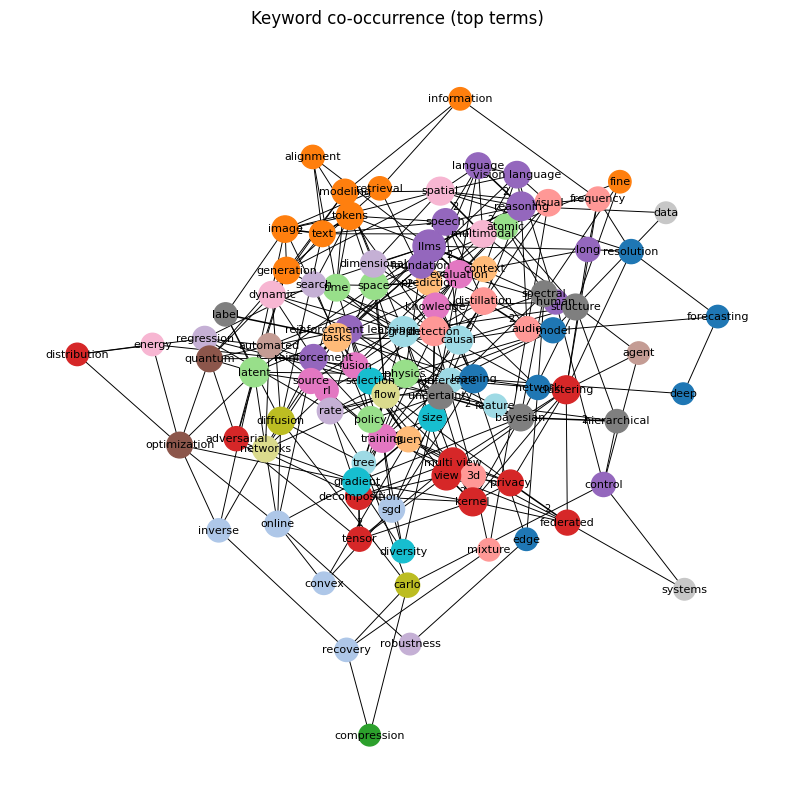

In [74]:
#подграф самых частых слов
TOP_N = 100
most_common_nodes = [t for t, _ in term_counts.most_common(TOP_N)]
subG = G_kw.subgraph(most_common_nodes).copy()


plt.figure(figsize=(10,10))
pos = nx.spring_layout(subG, seed=42)
#pos = nx.circular_layout(subG)
node_color = [node_community.get(n, 0) for n in subG.nodes()]
node_size = [200 + 20*subG.degree(n) for n in subG.nodes()]


nx.draw_networkx_nodes(subG, pos, node_size=node_size, cmap=plt.cm.tab20, node_color=node_color)
nx.draw_networkx_labels(subG, pos, font_size=8)
# ребра по весу
edges = subG.edges(data=True)
weights = [d['weight'] for (_,_,d) in edges]

# подписи весов только если вес > 1, иначе граф некрасивый
edge_labels = {
    (u, v): d['weight']
    for u, v, d in subG.edges(data=True)
    if d['weight'] > 1
}

nx.draw_networkx_edge_labels(
    subG,
    pos,
    edge_labels=edge_labels,
    font_size=7,
    label_pos=0.7,
    rotate=False
)

nx.draw_networkx_edges(subG, pos, width=[max(0.2, math.log(w+1)) for w in weights])
plt.title('Keyword co-occurrence (top terms)')
plt.axis('off')
plt.show()

Для графа публикаций далее - если слово из разных документов, ставим ребро.

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import itertools

# граф публикаций
P = nx.Graph()

# добавляем !публикации! как узлы
for idx, row in df.iterrows():
    P.add_node(idx, id=row['id'], title=row['title'])

# "ключевое слово → публикации"
term_to_docs = defaultdict(list)
for idx, kws in enumerate(df['keywords']):
    for kw in set(kws):
        term_to_docs[kw].append(idx)


for kw, docs in term_to_docs.items():
    for a, b in itertools.combinations(docs, 2):
        if P.has_edge(a, b):
            P[a][b]['weight'] += 1
        else:
            P.add_edge(a, b, weight=1)

print('Publication graph nodes=', P.number_of_nodes(), 'edges=', P.number_of_edges())


Визуализация:

Publication graph nodes= 258 edges= 1321


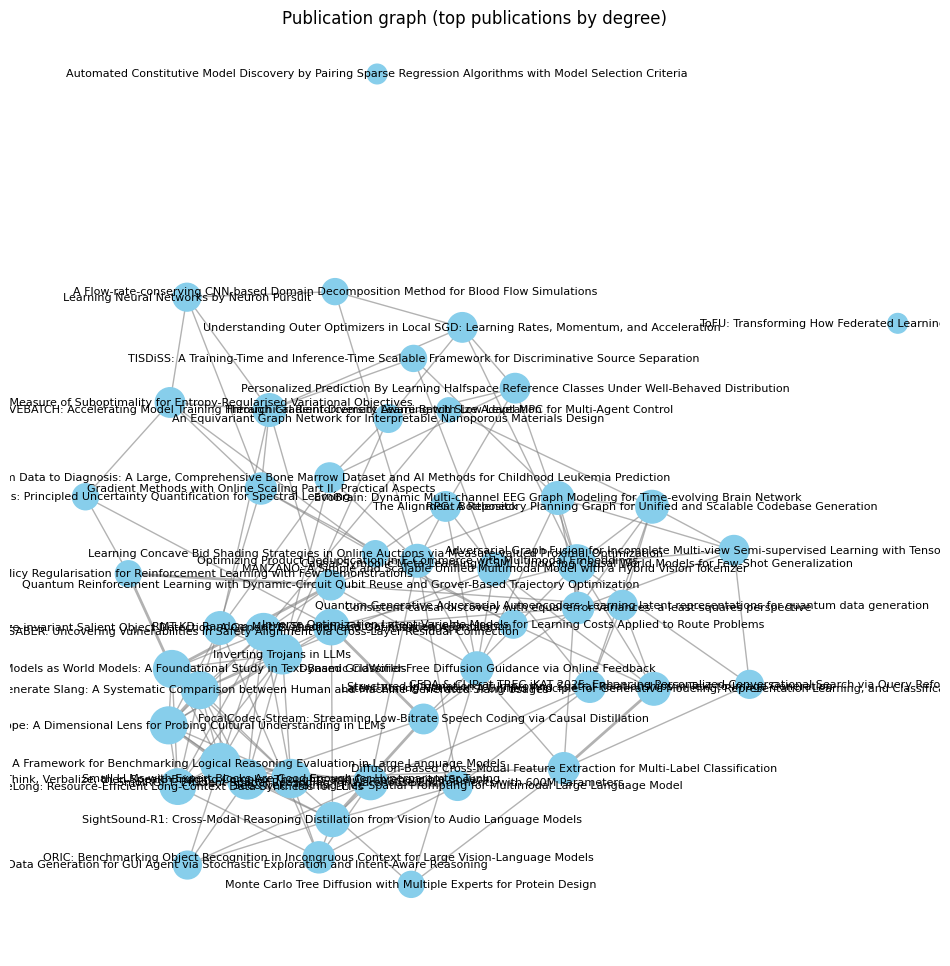

In [76]:
TOP_N = 50
top_nodes = sorted(P.degree, key=lambda x: x[1], reverse=True)[:TOP_N]
subP = P.subgraph([n for n, _ in top_nodes])

plt.figure(figsize=(12,12))
pos = nx.spring_layout(subP, k=0.5, seed=42)  # k регулирует плотность узлов

# размеры узлов по степени
node_size = [200 + 50*subP.degree(n) for n in subP.nodes()]

# веса ребер
edge_weights = [max(0.2, w['weight']) for u, v, w in subP.edges(data=True)]

nx.draw_networkx_nodes(subP, pos, node_size=node_size, node_color='skyblue')
nx.draw_networkx_edges(subP, pos, width=edge_weights, edge_color='gray', alpha=0.6)
nx.draw_networkx_labels(subP, pos, labels={n: subP.nodes[n]['title'] for n in subP.nodes()}, font_size=8)

plt.title("Publication graph (top publications by degree)")
plt.axis('off')
plt.show()


### Поиск похожих публикаций (по ключевым словам)

- Каждая публикация представлена как **узел** в графе `P`.
- Между двумя публикациями создаём **ребро**, если они имеют хотя бы одно общее ключевое слово.
- Атрибут ребра `weight` = число **общих ключевых слов** между публикациями.
- Для заданной публикации `pub_idx`:
  1. Берём всех её соседей в графе (публикации с общими словами).
  2. Сортируем по `weight` (число общих слов) в порядке убывания.
  3. Выбираем топ-k публикаций с наибольшим весом — это и есть **самые похожие публикации**.

**Вывод:** чем выше `weight`, тем больше общих ключевых слов между статьями и тем сильнее их схожесть.


In [30]:
def top_k_similar_papers(pub_idx, k=10):
    if pub_idx not in P:
        return []
    neighbors = P[pub_idx]
    ranked = sorted(neighbors.items(), key=lambda t: t[1].get('weight', 0), reverse=True)
    return [(nid, data.get('weight', 0), df.loc[nid, 'title']) for nid, data in ranked[:k]]


# глянем на топ-5 похожих
print('Top similar to 0:', top_k_similar_papers(0, 5))

Top similar to 0: [(13, 1, 'Network-Based Detection of Autism Spectrum Disorder Using Sustainable and Non-invasive Salivary Biomarkers'), (41, 1, 'The Missing Piece: A Case for Pre-Training in 3D Medical Object Detection'), (50, 1, 'From Data to Diagnosis: A Large, Comprehensive Bone Marrow Dataset and AI Methods for Childhood Leukemia Prediction'), (93, 1, 'Towards Size-invariant Salient Object Detection: A Generic Evaluation and Optimization Approach'), (1, 1, 'MANZANO: A Simple and Scalable Unified Multimodal Model with a Hybrid Vision Tokenizer')]


`term` — ключевое слово \
`count` — сколько раз оно встречается во всех документах \
`community` — к какому сообществу слово относится (из Louvain clustering) \
`degree_centrality` — центральность по степени (сколько соседей в графе слов) \
`betweenness` — центральность посредника (насколько слово соединяет разные части графа) \
`eigenvector` — центральность по важности соседей

In [101]:
#  Экспорт результатов и интерпретация
# Сохраним таблички с ключевыми словами, их сообществами и центральностями в CSV

# %%
term_df = pd.DataFrame({
'term': list(term_counts.keys()),
'count': [term_counts[t] for t in term_counts.keys()],
'community': [node_community.get(t, -1) for t in term_counts.keys()],
'degree_centrality': [centralities['degree'].get(t, 0) for t in term_counts.keys()],
'betweenness': [centralities['betweenness'].get(t, 0) for t in term_counts.keys()],
'eigenvector': [centralities['eigenvector'].get(t, 0) for t in term_counts.keys()],
}
)
term_df.sort_values('count', ascending=False, inplace=True)
term_df.to_csv('keyword_stats.csv', index=False)

# публикации с ключевыми
df_out = df[['id','title','authors','keywords']]
df_out.to_json('papers_with_keywords.json', orient='records', force_ascii=False)


print('Saved keyword_stats.csv and papers_with_keywords.json')

Saved keyword_stats.csv and papers_with_keywords.json



## Рекомендации и расширения
 - Для улучшения качества ключевых слов: добавить лемматизацию и POS-фильтрацию (оставлять только существительные/прилагательные) через spaCy;
 - Можно использовать RAKE / YAKE / KeyBERT для более качественной экстракции фраз (альтернативные методы извлечения ключевых фраз);
 - Для больших графов использовать pyspark/graph-tool/FAISS для ускорения; визуализации — Gephi или Cytoscape;
 - Для кластеризации публикаций можно использовать spectral clustering по матрице сходства.

